In [1]:
def grab_col_names(dataframe, cat_th=10, car_th=20):

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

def label_encoder(dataframe, binary_col):
    label_encoder = LabelEncoder()
    dataframe[binary_col] = label_encoder.fit_transform(dataframe[binary_col])
    return dataframe


def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

## IMPORT LIBRARIES

In [2]:
import pandas as pd
import numpy as np

import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec


from sklearn.ensemble import GradientBoostingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  GridSearchCV, cross_validate
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, \
    roc_auc_score, confusion_matrix
from sklearn.model_selection import  cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler

import mpu
from imblearn.combine import SMOTETomek

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.width', 200)

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('df_review_prediction.csv')

In [4]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_geolocation_lat,customer_geolocation_lng,order_purchase_year,order_purchase_month,order_purchase_day_of_week,order_purchase_hour,month_year,delivered_time,sale_price,customer_region,seller_region
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9000,13.2900,58.0000,598.0000,4.0000,650.0000,28.0000,9.0000,14.0000,cool_stuff,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,97ca439bc427b48bc1cd7177abe71365,5.0000,2017-09-21 00:00:00,2017-09-22 10:57:03,1.0000,credit_card,2.0000,72.1900,27277,volta redonda,SP,-22.4982,-44.1236,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,-21.7581,-41.3126,2017,9,2-Wed,8,2017-09,7.0000,72.1900,Southeast,Southeast
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9000,19.9300,56.0000,239.0000,2.0000,30000.0000,50.0000,30.0000,40.0000,pet_shop,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15 00:00:00,7b07bacd811c4117b742569b04ce3580,4.0000,2017-05-13 00:00:00,2017-05-15 11:34:13,1.0000,credit_card,3.0000,259.8300,3471,sao paulo,SP,-23.5663,-46.5184,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,-20.2124,-50.9415,2017,4,2-Wed,10,2017-04,16.0000,259.8300,Southeast,Southeast
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0000,17.8700,59.0000,695.0000,2.0000,3050.0000,33.0000,13.0000,33.0000,furniture_decor,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05 00:00:00,0c5b33dea94867d1ac402749e5438e8b,5.0000,2018-01-23 00:00:00,2018-01-23 16:06:31,1.0000,credit_card,5.0000,216.8700,37564,borda da mata,MG,-22.2641,-46.1586,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,-19.8604,-44.5980,2018,1,6-Sun,14,2018-01,7.0000,216.8700,Southeast,Southeast
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.9900,12.7900,42.0000,480.0000,1.0000,200.0000,16.0000,10.0000,15.0000,perfumery,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20 00:00:00,f4028d019cb58564807486a6aaf33817,4.0000,2018-08-15 00:00:00,2018-08-15 16:39:01,1.0000,credit_card,2.0000,25.7800,14403,franca,SP,-20.5482,-47.3959,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,-23.1449,-46.5398,2018,8,2-Wed,10,2018-08,6.0000,25.7800,Southeast,Southeast
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.9000,18.1400,59.0000,409.0000,1.0000,3750.0000,35.0000,40.0000,30.0000,garden_tools,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-17 00:00:00,940144190dcba6351888cafa43f3a3a5,5.0000,2017-03-02 00:00:00,2017-03-03 10:54:59,1.0000,credit_card,3.0000,218.0400,87900,loanda,PR,-22.9314,-53.1338,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,-23.2490,-46.8250,2017,2,5-Sat,13,2017-02,25.0000,218.0400,Southeast,South


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118307 entries, 0 to 118306
Data columns (total 49 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118307 non-null  object 
 1   order_item_id                  118307 non-null  int64  
 2   product_id                     118307 non-null  object 
 3   seller_id                      118307 non-null  object 
 4   shipping_limit_date            118307 non-null  object 
 5   price                          118307 non-null  float64
 6   freight_value                  118307 non-null  float64
 7   product_name_lenght            116598 non-null  float64
 8   product_description_lenght     116598 non-null  float64
 9   product_photos_qty             116598 non-null  float64
 10  product_weight_g               118287 non-null  float64
 11  product_length_cm              118287 non-null  float64
 12  product_height_cm             

In [6]:
df['shipping_limit_date'] = pd.to_datetime(df['shipping_limit_date'])
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_approved_at'] = pd.to_datetime(df['order_approved_at'])
df['order_delivered_carrier_date'] = pd.to_datetime(df['order_delivered_carrier_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'])
df['review_answer_timestamp'] = pd.to_datetime(df['review_answer_timestamp'])

### -Checking Missing Values 

In [7]:
(df.isnull().sum() * 100 / df.shape[0]).sort_values(ascending=False)[:20]

delivered_time                  2.2002
order_delivered_customer_date   2.1875
product_category_name_english   1.4657
product_name_lenght             1.4445
product_description_lenght      1.4445
product_photos_qty              1.4445
order_delivered_carrier_date    1.0600
review_answer_timestamp         0.8267
review_creation_date            0.8267
review_score                    0.8267
review_id                       0.8267
customer_geolocation_lat        0.2679
customer_geolocation_lng        0.2679
seller_geolocation_lat          0.2240
seller_geolocation_lng          0.2240
product_width_cm                0.0169
product_height_cm               0.0169
product_length_cm               0.0169
product_weight_g                0.0169
order_approved_at               0.0127
dtype: float64

- Since there are orders that have not yet been delivered in the data set, there are missing values in the relevant columns.

In [8]:
df.describe([.05, .1, .25, .75, .9, .95, .99]).T

,count,mean,std,min,5%,10%,25%,50%,75%,90%,95%,99%,max
order_item_id,118307.0000,1.1965,0.6995,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,2.0000,2.0000,4.0000,21.0000
price,118307.0000,120.6486,184.1116,0.8500,17.0000,23.7500,39.9000,74.9000,134.9000,229.9000,349.9000,895.0000,6735.0000
freight_value,118307.0000,20.0324,15.8370,0.0000,7.7800,8.7600,13.0800,16.2800,21.1800,34.1500,45.3000,84.9394,409.6800
product_name_lenght,116598.0000,48.7676,10.0334,5.0000,29.0000,33.0000,42.0000,52.0000,57.0000,59.0000,60.0000,63.0000,76.0000
product_description_lenght,116598.0000,785.9831,652.5855,4.0000,160.0000,213.0000,346.0000,600.0000,983.7500,1582.0000,2123.1500,3419.1500,3992.0000
product_photos_qty,116598.0000,2.2052,1.7175,1.0000,1.0000,1.0000,1.0000,1.0000,3.0000,5.0000,6.0000,8.0000,20.0000
product_weight_g,118287.0000,2112.2948,3786.7329,0.0000,125.0000,150.0000,300.0000,700.0000,1800.0000,6250.0000,9850.0000,18600.0000,40425.0000
product_length_cm,118287.0000,30.2654,16.1895,7.0000,16.0000,16.0000,18.0000,25.0000,38.0000,51.0000,62.0000,95.0000,105.0000
product_height_cm,118287.0000,16.6199,13.4537,2.0000,3.0000,4.0000,8.0000,13.0000,20.0000,31.0000,45.0000,65.0000,105.0000
product_width_cm,118287.0000,23.0749,11.7493,6.0000,11.0000,12.0000,15.0000,20.0000,30.0000,40.0000,45.0000,62.0000,118.0000


In [9]:
df_filtered_order_item = df.drop_duplicates(subset=['order_id', 'customer_unique_id'], keep='last')

- Order_item_id refers sequential number identifying a number of items included in the same order.If we keep the last unique customer number of each unique order number in the data set, we get the last order item id value in each order.

## FEATURE ENGINEERING

In [10]:
df_seller_count = df.groupby('customer_unique_id')['seller_id'].nunique().sort_values(ascending=False).reset_index()
df_seller_count.rename(columns={'seller_id': 'seller_count'}, inplace=True)
df = df.merge(df_seller_count, how='left', on='customer_unique_id')
df.loc[df['seller_count'] > 1, 'seller_count'] = '1 >'
df.loc[df['seller_count'] == 1, 'seller_count'] = '1'

In [11]:
df.drop_duplicates(subset=['order_id'], keep='first').groupby('seller_count')['review_score'].agg({'count', 'mean'}).reset_index()

,seller_count,count,mean
0,1,92299,4.1176
1,1 >,5616,3.8994


- Based on the insight that orders with more sellers have lower review scores, we can create a new column.

In [12]:
df_filtered_order_item.loc[df_filtered_order_item['order_item_id'] > 3, 'order_item_cat'] = '3 >'
df_filtered_order_item.loc[(df_filtered_order_item['order_item_id'] == 2) | (df_filtered_order_item['order_item_id'] == 3), 'order_item_cat'] = '2-3'
df_filtered_order_item.loc[df_filtered_order_item['order_item_id'] == 1, 'order_item_cat'] = '1'
df_filtered_order_item = df_filtered_order_item[['order_id', 'order_item_cat']]
df = df.merge(df_filtered_order_item, how='inner', on='order_id')

In [13]:
df.drop_duplicates(subset=['order_id'], keep='first').groupby('order_item_cat')['review_score'].agg({'count', 'mean'}).reset_index()

,order_item_cat,count,mean
0,1,88226,4.1603
1,2-3,8739,3.6336
2,3 >,950,3.3211


- We can use the inference that orders with fewer products have a high review score to create a new column.

In [14]:
df.loc[df['payment_installments'] > 8, 'installments_cat'] = '9 >'
df.loc[(df['payment_installments'] >= 3) & (df['payment_installments'] <= 8) , 'installments_cat'] = '3-8'
df.loc[df['payment_installments'] < 3, 'installments_cat'] = '1-2'

In [15]:
df.drop_duplicates(subset=['order_id'], keep='first').groupby('installments_cat')['review_score'].agg({'count', 'mean'}).reset_index()

,installments_cat,count,mean
0,1-2,59964,4.1365
1,3-8,31844,4.0672
2,9 >,6106,3.9949


- There is a negative relationship between the number of installments and the review score.

In [16]:
df.loc[df['order_status'] == 'delivered', 'delivered_yes_no'] = 'delivered'
df.loc[df['order_status'] != 'delivered', 'delivered_yes_no'] = 'not_delivered'

In [17]:
df.drop_duplicates(subset=['order_id'], keep='first').groupby('delivered_yes_no')['review_score'].agg({'count', 'mean'}).reset_index()

,delivered_yes_no,count,mean
0,delivered,95830,4.1563
1,not_delivered,2085,1.7535


In [18]:
df['volume'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
df['weight_freight'] = df['product_weight_g'] * df['freight_value']
df['freight_price'] = df['freight_value'] / df['payment_value']
df['purchase_limit'] = (df['shipping_limit_date'] - df['order_purchase_timestamp']).dt.days
df['delcarrier_purchase'] = (df['order_delivered_carrier_date'] - df['order_purchase_timestamp']).dt.days
df['estimated_purchase'] = (df['order_estimated_delivery_date'] - df['order_purchase_timestamp']).dt.days
df['estimated_delivered'] = (df['order_estimated_delivery_date'] - df['order_delivered_customer_date']).dt.days

- **volume** : It depicts the volume of items. There is a positive relationship between volume of the items and delivery time. Delivery times of the items with higher volume are also longer.  
- **purchase_limit** : It indicates the difference in days between the shipping limit date and the order date. 
- **delcarrier_purchase** : It represents the difference between the order date and the delivery date of the order to the carrier.  
- **estimated_purchase** : It indicates the estimated number of days the order will be delivered.  
- **estimated_delivered** : It indicates the difference between the estimated delivery date of the order and the actual delivery date. A negative value indicates that the order was delivered later than the estimated time.

### -Category Reduction

In [19]:
df['product_category_name_english'].nunique()

71

- Although there are 71 unique categories in the dataset, some categories are similar and these categories can be associated.

In [20]:
home_appliances = ['home_appliances', 'small_appliances', 'air_conditioning', 'home_appliances_2', 'small_appliances_home_oven_and_coffee',
                   'kitchen_dining_laundry_garden_furniture', 'la_cuisine']
df.loc[df['product_category_name_english'].isin(home_appliances), 'product_category_name_english'] = 'home_appliances'

home_construction = ['home_construction', 'construction_tools_construction' ,'construction_tools_lights',
                     'construction_tools_safety', 'costruction_tools_tools']
df.loc[df['product_category_name_english'].isin(home_construction), 'product_category_name_english'] = 'home_construction'

stationery = ['books_general_interest', 'books_technical', 'books_imported']
df.loc[df['product_category_name_english'].isin(stationery), 'product_category_name_english'] = 'stationery'

furniture_decor = ['furniture_living_room', 'home_confort', 'furniture_bedroom', 'furniture_mattress_and_upholstery', 'home_comfort_2']
df.loc[df['product_category_name_english'].isin(furniture_decor), 'product_category_name_english'] = 'furniture_decor'

food_drinks = ['food', 'drinks' , 'market_place', 'food_drink']
df.loc[df['product_category_name_english'].isin(food_drinks), 'product_category_name_english'] = 'food_drinks'

houseware = ['kitchen_dining_laundry_garden_furniture', 'la_cuisine']
df.loc[df['product_category_name_english'].isin(houseware), 'product_category_name_english'] = 'houseware'

fashion_bags_accessories =['fashion_shoes', 'fashion_male_clothing', 'fashion_underwear_beach', 'fashio_female_clothing',
                           'fashion_sport', 'fashion_childrens_clothes']
df.loc[df['product_category_name_english'].isin(fashion_bags_accessories), 'product_category_name_english'] = 'fashion_bags_accessories'

telephony = ['fixed_telephony']
df.loc[df['product_category_name_english'].isin(telephony), 'product_category_name_english'] = 'telephony'

commerce = ['industry_commerce_and_business', 'agro_industry_and_commerce']
df.loc[df['product_category_name_english'].isin(commerce), 'product_category_name_english'] = 'commerce'

computers_accessories = ['computers', 'tablets_printing_image']
df.loc[df['product_category_name_english'].isin(computers_accessories), 'product_category_name_english'] = 'computers_accessories'

sport_leiseure = ['art', 'arts_and_craftmanship']
df.loc[df['product_category_name_english'].isin(sport_leiseure), 'product_category_name_english'] = 'sports_leisure'

electronics = ['signaling_and_security', 'cine_photo', 'dvds_blu_ray', 'cds_dvds_musicals', 'musical_instruments', 'audio', 'music', 'security_and_services']
df.loc[df['product_category_name_english'].isin(electronics), 'product_category_name_english'] = 'electronics'

watches_gifts =  ['christmas_supplies', 'party_supplies']
df.loc[df['product_category_name_english'].isin(watches_gifts), 'product_category_name_english'] = 'watches_gifts'

baby = ['diapers_and_hygiene']
df.loc[df['product_category_name_english'].isin(baby), 'product_category_name_english'] = 'baby'

garden_tools = ['flowers', 'costruction_tools_garden']
df.loc[df['product_category_name_english'].isin(garden_tools), 'product_category_name_english'] = 'garden_tools'

### -Rare Cities

- We can name the rare cities in the dataset as 'rare'.

In [21]:
rare_columns = ['seller_city', 'customer_city']
temp_df = df.copy()
for var in rare_columns: 
    tmp = temp_df[var].value_counts() / len(temp_df)
    rare_labels = tmp[tmp < 0.01].index
    temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])
df = temp_df

### - Handling Missing Values

In [23]:
df.dropna(subset=['customer_geolocation_lng', 'customer_geolocation_lat',
                  'seller_geolocation_lng', 'seller_geolocation_lat', 'review_score'], inplace=True)

In [24]:
df['estimated_delivered'] = df.groupby(['customer_region', 'seller_region']).estimated_delivered.apply(lambda x: x.fillna(x.mean()))
df['product_photos_qty'] = df.groupby(['product_category_name_english']).product_photos_qty.apply(lambda x: x.fillna(x.mean()))
df['delcarrier_purchase'] = df.groupby(['customer_region', 'seller_region']).estimated_delivered.apply(lambda x: x.fillna(x.mean()))
df['product_category_name_english'] = df['product_category_name_english'].fillna(df['product_category_name_english'].mode()[0])

In [25]:
df = df.reset_index(drop=True)

### -Finding The Distance Between Seller and Customer

**Haversine Formula** : The haversine formula determines the great-circle distance between two points on a sphere given their longitudes and latitudes. Important in navigation, it is a special case of a more general formula in spherical trigonometry, the law of haversines, that relates the sides and angles of spherical triangles.

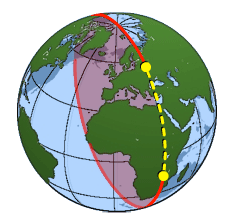

In [26]:
dist = []
for i in range(0, len(df)):
    dist.append(mpu.haversine_distance((df['customer_geolocation_lat'][i], df['customer_geolocation_lng'][i]),
                                       (df['seller_geolocation_lat'][i], df['seller_geolocation_lng'][i])))

In [27]:
df['seller_customer_distance'] = dist

In [28]:
df.groupby('review_score')['seller_customer_distance'].mean().reset_index()

,review_score,seller_customer_distance
0,1.0000,654.1502
1,2.0000,640.6382
2,3.0000,628.6461
3,4.0000,619.9542
4,5.0000,568.5846


- The average haversine distance of the orders with a review score of 5 is quite low compared to the others.

In [29]:
df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,review_id,review_score,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value,seller_zip_code_prefix,seller_city,seller_state,seller_geolocation_lat,seller_geolocation_lng,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,customer_geolocation_lat,customer_geolocation_lng,order_purchase_year,order_purchase_month,order_purchase_day_of_week,order_purchase_hour,month_year,delivered_time,sale_price,customer_region,seller_region,seller_count,order_item_cat,installments_cat,delivered_yes_no,volume,weight_freight,freight_price,purchase_limit,delcarrier_purchase,estimated_purchase,estimated_delivered,seller_customer_distance
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9000,13.2900,58.0000,598.0000,4.0000,650.0000,28.0000,9.0000,14.0000,cool_stuff,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29,97ca439bc427b48bc1cd7177abe71365,5.0000,2017-09-21,2017-09-22 10:57:03,1.0000,credit_card,2.0000,72.1900,27277,Rare,SP,-22.4982,-44.1236,871766c5855e863f6eccc05f988b23cb,28013,Rare,RJ,-21.7581,-41.3126,2017,9,2-Wed,8,2017-09,7.0000,72.1900,Southeast,Southeast,1,1,1-2,delivered,3528.0000,8638.5000,0.1841,6,8.0000,15,8.0000,301.0057
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.9000,19.9300,56.0000,239.0000,2.0000,30000.0000,50.0000,30.0000,40.0000,pet_shop,delivered,2017-04-26 10:53:06,2017-04-26 11:05:13,2017-05-04 14:35:00,2017-05-12 16:04:24,2017-05-15,7b07bacd811c4117b742569b04ce3580,4.0000,2017-05-13,2017-05-15 11:34:13,1.0000,credit_card,3.0000,259.8300,3471,sao paulo,SP,-23.5663,-46.5184,eb28e67c4c0b83846050ddfb8a35d051,15775,Rare,SP,-20.2124,-50.9415,2017,4,2-Wed,10,2017-04,16.0000,259.8300,Southeast,Southeast,1 >,1,3-8,delivered,60000.0000,597900.0000,0.0767,7,2.0000,18,2.0000,589.2741
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.0000,17.8700,59.0000,695.0000,2.0000,3050.0000,33.0000,13.0000,33.0000,furniture_decor,delivered,2018-01-14 14:33:31,2018-01-14 14:48:30,2018-01-16 12:36:48,2018-01-22 13:19:16,2018-02-05,0c5b33dea94867d1ac402749e5438e8b,5.0000,2018-01-23,2018-01-23 16:06:31,1.0000,credit_card,5.0000,216.8700,37564,Rare,MG,-22.2641,-46.1586,3818d81c6709e39d06b2738a8d3a2474,35661,Rare,MG,-19.8604,-44.5980,2018,1,6-Sun,14,2018-01,7.0000,216.8700,Southeast,Southeast,1,1,3-8,delivered,14157.0000,54503.5000,0.0824,4,13.0000,21,13.0000,312.4950
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.9900,12.7900,42.0000,480.0000,1.0000,200.0000,16.0000,10.0000,15.0000,perfumery,delivered,2018-08-08 10:00:35,2018-08-08 10:10:18,2018-08-10 13:28:00,2018-08-14 13:32:39,2018-08-20,f4028d019cb58564807486a6aaf33817,4.0000,2018-08-15,2018-08-15 16:39:01,1.0000,credit_card,2.0000,25.7800,14403,Rare,SP,-20.5482,-47.3959,af861d436cfc08b2c2ddefd0ba074622,12952,Rare,SP,-23.1449,-46.5398,2018,8,2-Wed,10,2018-08,6.0000,25.7800,Southeast,Southeast,1,1,1-2,delivered,2400.0000,2558.0000,0.4961,7,5.0000,11,5.0000,301.9518
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.9000,18.1400,59.0000,409.0000,1.0000,3750.0000,35.0000,40.0000,30.0000,garden_tools,delivered,2017-02-04 13:57:51,2017-02-04 14:10:13,2017-02-16 09:46:09,2017-03-01 16:42:31,2017-03-

In [30]:
df = df.drop_duplicates(subset=['order_id', 'product_id'], keep='first')

In [31]:
df.shape

(101121, 61)

In [32]:
df.drop(['product_weight_g', 'seller_state', 'price','product_length_cm', 'product_height_cm', 'product_width_cm', 'order_item_id', 'customer_state','order_id',
         'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'product_name_lenght',
         'product_description_lenght','order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_estimated_delivery_date',
         'order_delivered_customer_date', 'review_id','review_creation_date', 'review_answer_timestamp', 'seller_zip_code_prefix', 'customer_unique_id',
         'customer_zip_code_prefix', 'order_purchase_year', 'customer_geolocation_lng', 'customer_geolocation_lat', 'seller_geolocation_lng', 
         'seller_geolocation_lat', 'order_purchase_day_of_week', 'order_purchase_hour', 'order_purchase_month', 'delivered_time', 'order_status',
         'payment_installments'], axis=1, inplace=True)

In [33]:
df.dropna(inplace=True)

In [34]:
df.shape

(99656, 25)

**The data set is ready to build the model.**

In [35]:
df.head()

,freight_value,product_photos_qty,product_category_name_english,review_score,payment_sequential,payment_type,payment_value,seller_city,customer_city,month_year,sale_price,customer_region,seller_region,seller_count,order_item_cat,installments_cat,delivered_yes_no,volume,weight_freight,freight_price,purchase_limit,delcarrier_purchase,estimated_purchase,estimated_delivered,seller_customer_distance
0,13.2900,4.0000,cool_stuff,5.0000,1.0000,credit_card,72.1900,Rare,Rare,2017-09,72.1900,Southeast,Southeast,1,1,1-2,delivered,3528.0000,8638.5000,0.1841,6,8.0000,15,8.0000,301.0057
1,19.9300,2.0000,pet_shop,4.0000,1.0000,credit_card,259.8300,sao paulo,Rare,2017-04,259.8300,Southeast,Southeast,1 >,1,3-8,delivered,60000.0000,597900.0000,0.0767,7,2.0000,18,2.0000,589.2741
2,17.8700,2.0000,furniture_decor,5.0000,1.0000,credit_card,216.8700,Rare,Rare,2018-01,216.8700,Southeast,Southeast,1,1,3-8,delivered,14157.0000,54503.5000,0.0824,4,13.0000,21,13.0000,312.4950
3,12.7900,1.0000,perfumery,4.0000,1.0000,credit_card,25.7800,Rare,Rare,2018-08,25.7800,Southeast,Southeast,1,1,1-2,delivered,2400.0000,2558.0000,0.4961,7,5.0000,11,5.0000,301.9518
4,18.1400,1.0000,garden_tools,5.0000,1.0000,credit_card,218.0400,Rare,Rare,2017-02,218.0400,Southeast,South,1,1,3-8,delivered,42000.0000,68025.0000,0.0832,9,15.0000,40,15.0000,646.2218


In [36]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 99656
Variables: 25
cat_cols: 11
num_cols: 12
cat_but_car: 2
num_but_cat: 2


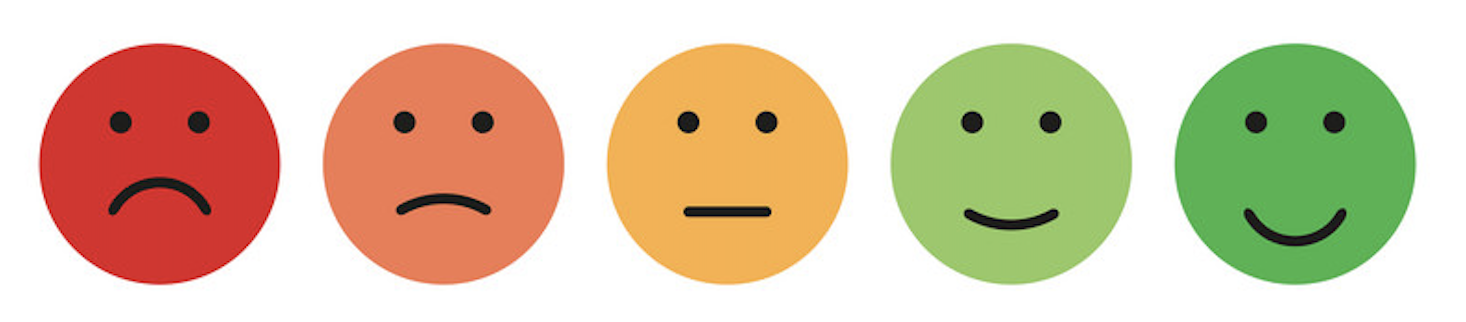

** The study will be evaluated as a binary classification, and those with a review score equal to or below 3 will be evaluated as negative, and those with 4 and 5 will be evaluated as positive.

In [37]:
df['review_score'] = np.where(df.review_score <= 3, 0, 1)

### -Encoding & Feature Scaling

In [38]:
cat_cols = ['payment_type', 'seller_city', 'customer_city', 'customer_region', 'seller_region', 'payment_sequential', 'installments_cat', 'order_item_cat']

In [39]:
binary_cols = ['seller_count', 'delivered_yes_no']

for col in binary_cols:
    label_encoder(df, col)

In [40]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols)
df = one_hot_encoder(df, cat_but_car)

In [41]:
rs = RobustScaler()
df[num_cols] = rs.fit_transform(df[num_cols])

In [42]:
df.shape

(99656, 108)

In [43]:
y = df[['review_score']]
X = df.drop('review_score', axis=1)

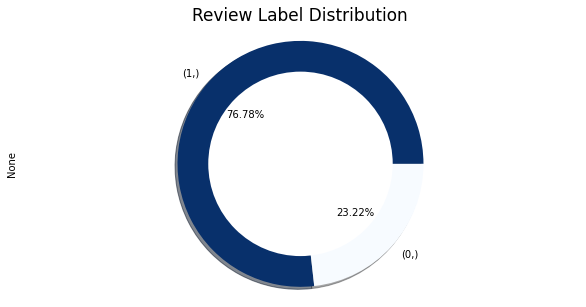

In [44]:
plt.figure(figsize=(10, 5))
ax = y.value_counts().plot(kind='pie', autopct='%1.2f%%', cmap='Blues_r', shadow=True)
centre_circle = plt.Circle((0, 0),0.75, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')
ax.set_title('Review Label Distribution', fontsize=17, y=1.0, pad=7)
plt.show()

### -Imbalanced Data  

A classification data set with skewed class proportions is called imbalanced. Classes that make up a large proportion of the data set are called majority classes. Those that make up a smaller proportion are minority classes.

| Degree of imbalance        | Proportion of Minority Class          |
| ------------- |:-------------:|
| Mild      | 20-40% of the data set |
| Moderate      | 1-20% of the data set      |   
| Extreme| <1% of the data set     |    

The our data set is in the category of mild imbalanced data set.

**SmoteTomek**: SMOTE is an oversampling technique and creates new minority class synthetic samples, and Tomek Links is an undersampling technique.

For an imbalanced dataset, first SMOTE is applied to create new synthetic minority samples to get a balanced distribution. Further, Tomek Links is used in removing the samples close to the boundary of the two classes, to increase the separation between the two classes.

In [45]:
smt = SMOTETomek(random_state=5)
X_stomek, y_stomek = smt.fit_resample(X, y)

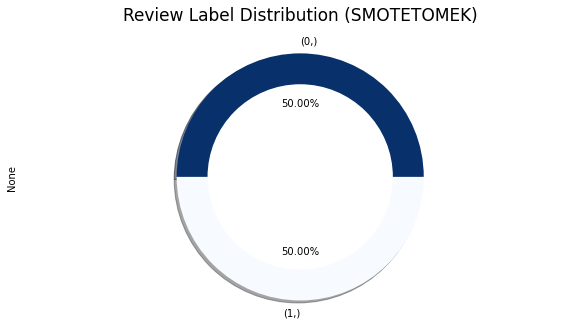

In [47]:
plt.figure(figsize=(10, 5))
ax = y_stomek.value_counts().plot(kind='pie', autopct='%1.2f%%', cmap='Blues_r', shadow=True)
centre_circle = plt.Circle((0, 0),0.75, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax.axis('equal')
ax.set_title('Review Label Distribution (SMOTETOMEK)', fontsize=17, y=1.05, pad=7)
plt.show()

## MODEL CREATION

**Cross Validation** : Cross-validation is a technique for evaluating ML models by training several ML models on subsets of the available input data and evaluating them on the complementary subset of the data. Use cross-validation to detect overfitting, ie, failing to generalize a pattern. There's no need to split the dataset into training and testing sets when you use cross-validation to measure the accuracy of the model.

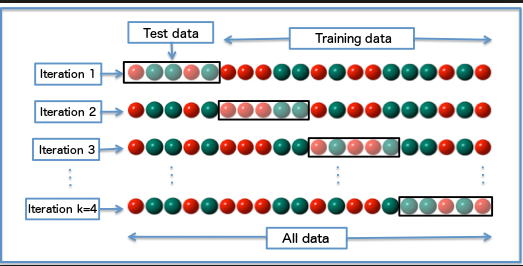


In [48]:
log_model = LogisticRegression()
gbm_model = GradientBoostingClassifier()
lgbm_model = LGBMClassifier()
catboost_model = CatBoostClassifier(verbose=False)
xgboost_model = XGBClassifier(use_label_encoder=False)

In [49]:
models = [log_model, gbm_model, lgbm_model, catboost_model, xgboost_model]
model_scores_train = pd.DataFrame(columns=['accuracy_mean', 'f1_mean', 'roc_auc_mean', 'models', 'smote_or_not'])
model_scores_test = pd.DataFrame(columns=['accuracy_mean', 'f1_mean', 'roc_auc_mean', 'models', 'smote_or_not'])

In [50]:
for model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=True)
    model_scores_train = model_scores_train.append({'accuracy_mean': cv_results['train_accuracy'].mean(),
                                                    'f1_mean': cv_results['train_f1'].mean(),
                                                    'roc_auc_mean': cv_results['train_roc_auc'].mean(),
                                                    'models': type(model).__name__,
                                                    'smote_or_not': 'not_smote'}, ignore_index=True)

[22:39:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:39:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:40:08] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:40:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [51]:
for model in models:
    cv_results = cross_validate(model, X, y, cv=5, scoring=['accuracy', 'f1', 'roc_auc'])
    model_scores_test = model_scores_test.append({'accuracy_mean': cv_results['test_accuracy'].mean(),
                                                  'f1_mean': cv_results['test_f1'].mean(),
                                                  'roc_auc_mean': cv_results['test_roc_auc'].mean(),
                                                  'models': type(model).__name__,
                                                  'smote_or_not': 'not_smote'}, ignore_index=True)

[22:44:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:23] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[22:45:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [53]:
for model in models:
    cv_results = cross_validate(model, X_stomek, y_stomek, cv=5, scoring=['accuracy', 'f1', 'roc_auc'], return_train_score=True)
    model_scores_train = model_scores_train.append({'accuracy_mean': cv_results['train_accuracy'].mean(),
                                                    'f1_mean': cv_results['train_f1'].mean(),
                                                    'roc_auc_mean': cv_results['train_roc_auc'].mean(),
                                                    'models': type(model).__name__,
                                                    'smote_or_not': 'smote'}, ignore_index=True)

[23:08:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:05] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:28] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:09:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [54]:
for model in models:
    cv_results = cross_validate(model, X_stomek, y_stomek, cv=5, scoring=['accuracy', 'f1', 'roc_auc'])
    model_scores_test = model_scores_test.append({'accuracy_mean': cv_results['test_accuracy'].mean(),
                                                  'f1_mean': cv_results['test_f1'].mean(),
                                                  'roc_auc_mean': cv_results['test_roc_auc'].mean(),
                                                  'models': type(model).__name__,
                                                  'smote_or_not': 'smote'}, ignore_index=True)

[23:20:09] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:20:37] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:02] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:21:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

## MODEL EVALUATION

In [55]:
model_scores_train.sort_values(by='roc_auc_mean', ascending=False).reset_index(drop=True)

,accuracy_mean,f1_mean,roc_auc_mean,models,smote_or_not
0,0.8982,0.9059,0.9522,CatBoostClassifier,smote
1,0.8936,0.9015,0.9474,XGBClassifier,smote
2,0.8818,0.8911,0.9269,LGBMClassifier,smote
3,0.8220,0.8411,0.8873,GradientBoostingClassifier,smote
4,0.7954,0.8103,0.8627,LogisticRegression,smote
5,0.8442,0.9063,0.8491,XGBClassifier,not_smote
6,0.8413,0.9046,0.8384,CatBoostClassifier,not_smote
7,0.8300,0.8980,0.7936,LGBMClassifier,not_smote
8,0.8206,0.8929,0.7448,GradientBoostingClassifier,not_smote
9,0.8086,0.8867,0.7267,LogisticRegression,not_smote


In [56]:
model_scores_test.sort_values(by='roc_auc_mean', ascending=False).reset_index(drop=True)

,accuracy_mean,f1_mean,roc_auc_mean,models,smote_or_not
0,0.8740,0.8966,0.9202,CatBoostClassifier,smote
1,0.8689,0.8920,0.9153,LGBMClassifier,smote
2,0.8663,0.8888,0.9153,XGBClassifier,smote
3,0.8127,0.8400,0.8782,GradientBoostingClassifier,smote
4,0.7853,0.8091,0.8548,LogisticRegression,smote
5,0.8196,0.8917,0.7410,CatBoostClassifier,not_smote
6,0.8193,0.8917,0.7401,LGBMClassifier,not_smote
7,0.8181,0.8915,0.7330,GradientBoostingClassifier,not_smote
8,0.8178,0.8905,0.7299,XGBClassifier,not_smote
9,0.8082,0.8864,0.7241,LogisticRegression,not_smote


- Models including the Smote tomek method gave much more successful results. Hyperparameter optimization will be made for the two most successful models, and the success of the models will be tried to be improved. 

**Hyperparameter Optimization**: In machine learning, hyperparameter optimization or tuning is the problem of choosing a set of optimal hyperparameters for a learning algorithm.The same kind of machine learning model can require different constraints, weights or learning rates to generalize different data patterns. These measures are called hyperparameters, and have to be tuned so that the model can optimally solve the machine learning problem. Hyperparameter optimization finds a tuple of hyperparameters that yields an optimal model which minimizes a predefined loss function on given independent data.

### - Hyperparameter Optimization  

#### 1. LGBM Model

In [57]:
lgbm_params = {'learning_rate': [0.01, 0.05, 0.1],
               'n_estimators': [100, 500, 1000],
               'num_leaves': [14, 31, 50, 70],
               'max_depth': [-1, 3, 5, 7, 10],
               'colsample_bytree': [0.6, 0.8, 1]
              }

In [58]:
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=False).fit(X_stomek, y_stomek.values.ravel())

In [59]:
lgbm_best_grid.best_params_

{'colsample_bytree': 1,
 'learning_rate': 0.05,
 'max_depth': -1,
 'n_estimators': 1000,
 'num_leaves': 70}

In [60]:
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_).fit(X_stomek, y_stomek)

In [61]:
cv_results = cross_validate(lgbm_final, X_stomek, y_stomek, cv=5, scoring=['accuracy', 'f1', 'roc_auc'])

In [62]:
print('Test accuracy :', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test Roc Auc:', cv_results['test_roc_auc'].mean())

Test accuracy : 0.8744297252755409
Test F1: 0.8963240373739154
Test Roc Auc: 0.9216277456625079


| Metrics       | Before Hyperparameter Optimization         | After Hyperparameter Optimization  |
| ------------- |:-------------:| -----:|
| Accuracy      | 0.8689 | 0.8744 |
| F1      | 0.8920     |   0.8963 |
| ROC-AUC | 0.9153      |    0.9216 |



In [63]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature",palette='Blues_r', data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

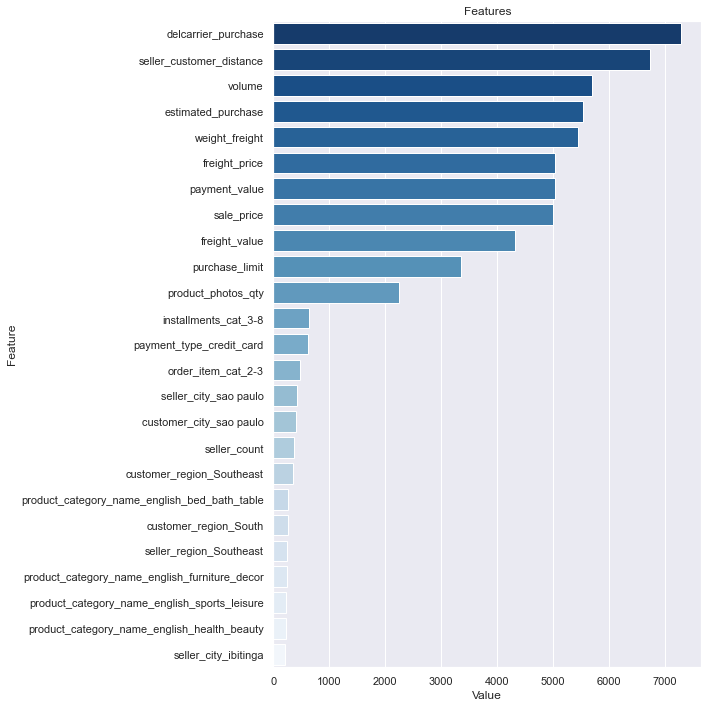

In [65]:
plot_importance(lgbm_final, X_stomek, 25)

#### 2.Catbost Model

In [66]:
catboost_params = {'depth': [3, 5, 7, 10],
                   'learning_rate': [0.01, 0.05, 0.1],
                   'iterations': [100, 500, 1000]
                   }

In [67]:
catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=False).fit(X_stomek, y_stomek)

In [68]:
catboost_best_grid.best_params_

{'depth': 10, 'iterations': 1000, 'learning_rate': 0.05}

In [69]:
catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_).fit(X_stomek, y_stomek)

In [70]:
cv_results = cross_validate(catboost_final, X_stomek, y_stomek, cv=5, scoring=['accuracy', 'f1', 'roc_auc'])

In [71]:
print('Test accuracy :', cv_results['test_accuracy'].mean())
print('Test F1:', cv_results['test_f1'].mean())
print('Test Roc Auc:', cv_results['test_roc_auc'].mean())

Test accuracy : 0.8758314625475414
Test F1: 0.8974418275713936
Test Roc Auc: 0.9232124308267693


| Metrics       | Before Hyperparameter Optimization         | After Hyperparameter Optimization  |
| ------------- |:-------------:| -----:|
| Accuracy      | 0.8740 | 0.8758 |
| F1      | 0.8966     |   0.8974 |
| ROC-AUC | 0.9202      |    0.9232 |



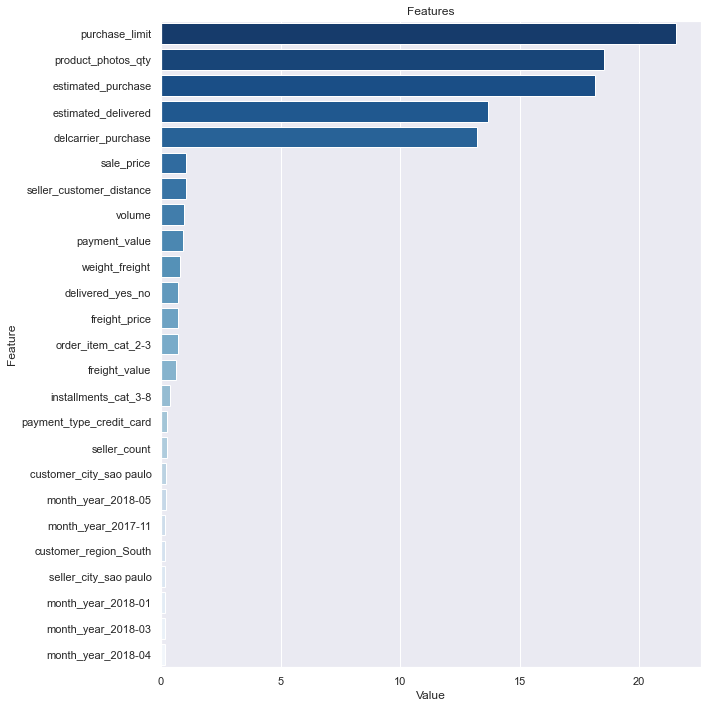

In [73]:
plot_importance(catboost_final, X_stomek, 25)

## CONCLUSION / SUGGESTIONS 

- The results of the lgbm and catboost models are very close and successful.The most important features for created models are:
  - delcarrier_purchase
  - seller_customer_distance
  - volume
  - estimated_purchase
  - purchase_limit 
  - product_photos_qty
  - estimated_delivered
  
  
- Sellers should follow the shipping processes of the items and offer promotions and campaigns to the customer if the order is not delivered by the estimated delivery date.  
- If the cargo limit dates of the items that the customer is likely to purchase are approaching, offers should be presented to the customer in a way that will speed up the sales process. 
- Especially in cases where the delivery time is likely to be long (the seller is far from the customer, heavy items, etc.) , small gifts should be placed in the packages.  
- Useful order monitoring systems should be established for customers.  
- Digital, fast solutions should be offered in logistics.
- Sellers should be transparent in the shipping process.
- After-sales services should be improved. 
- The order processes of customers who purchase products with more published photos should be monitored more closely.